<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc">
    <ul class="toc-item">
        <li>
            <span>
                <a href="#Assumptions" data-toc-modified-id="Assumptions-1">
                    <span class="toc-item-num">1&nbsp;&nbsp;</span>Assumptions
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#Load-Libraries" data-toc-modified-id="Load-Libraries-2">
                    <span class="toc-item-num">2&nbsp;&nbsp;</span>Load Libraries
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#Utilities" data-toc-modified-id="Utilities-3">
                    <span class="toc-item-num">3&nbsp;&nbsp;</span>Utilities
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#Trains-and-Blocks" data-toc-modified-id="Trains-and-Blocks-4">
                    <span class="toc-item-num">4&nbsp;&nbsp;</span>Trains and Blocks
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#Comparing-Simulation-Traces" data-toc-modified-id="Comparing-Simulation-Traces-5">
                    <span class="toc-item-num">5&nbsp;&nbsp;</span>Comparing Simulation Traces
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#Simulation-and-Optimization" data-toc-modified-id="Simulation-and-Optimization-6">
                    <span class="toc-item-num">6&nbsp;&nbsp;</span>Simulation and Optimization
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#Optimization-matrix" data-toc-modified-id="Optimization-matrix-7">
                    <span class="toc-item-num">7&nbsp;&nbsp;</span>Results
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#References" data-toc-modified-id="References-8">
                    <span class="toc-item-num">8&nbsp;&nbsp;</span>References
                </a>
            </span>
        </li>
    </ul>
</div>

# Assumptions

1. Only one block is considered between London Euston and London Old Oak
2. The tow blocks between Birmingham Interchange and Curzon Street are considered equal distance.
3. The blocks between London Old Oak Common and Birmingham Interchange are assumed to be equi-distant.
4. A pre-signal is considered 9,640 meters before the each signal (which is located at the end of each block). This is to consider the deccelaration distance of the train if required.
5. The wind and weather conditions are achieved by introducing random delays between the blocks (Old Oak and Birmingham). This wont impact the acceleration and deccelaration time of the train.
6. Passengers at the station are introduced using Poisson distribution with 500 arriving per hour.
7. Train is halted for 5 seconds at the station for passengers' boarding and alighting.
8. Further delay is introducted at the station in case of passengers' overcrowding.
9. Frequency of the short train and long train is taken in the ratio 1:3, i.e. one long train after 2 short trains.


# Load Libraries

In [31]:
import simpy
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline
import ctypes
import random


# Global Variables

These variables are made global as their scope is expected to retain in more than one functions to calculate the passengers backlog

In [32]:
#lists used to track the passenger arrival counts at each station
Euston_pass_arr = [] 
Old_Oak_pass_arr = []
Interchange_pass_arr = []

# Utilities

Function for Time Conversion

In [33]:
""" Convert time """
def daytime(t):
  t = int(t)
  return f"{t//3600:02d}:{(t%3600)//60:02d}:{t%60:02d}"

Function to populate the train schedule in a python dataframe

In [34]:
""" Summary of travel time and delay """
def train_schedule(df_summary):
    df_temp1 = df_summary[(df_summary[['Travel_Time']] != 0).all(axis=1)]
    df_temp2 = df_summary[(df_summary[['Delay']]).all(axis=1)]
    mean_travel_time = df_temp1["Travel_Time"].mean()
    punctuality = round(np.array(df_temp2["Delay"]).mean(),1)
    return mean_travel_time, punctuality

Function for the Stations (using pandas dataframe)

In [35]:
""" Schedule """
def Stations(trains, blocks_BC_input):
    train_frequence = 60*60/trains
    blocks_CD_input = 2

    # Creating main Data Frame with station and block arrival time (empty for now)
    column_names = ["Euston", "Old_Oak_Arrived", "Old_Oak_Dep_Expected"]
    df = pd.DataFrame(columns = column_names)

    for z in range(trains):
        Train = "Train" + str((z+1))
        df.at[Train] = 0

    for z in range(blocks_BC_input):        
        df[f'Block{z+1}'] = np.nan
    
    df.loc[:,'Interchange'] = pd.Series(0, index=df.index)

    for z in range(blocks_CD_input):
        df.at[f'Train{z+1}', f'BlockIC{z+1}'] = np.nan
    
    df.loc[:,'Curzon_Arrived'] = pd.Series(0, index=df.index)
    df.loc[:,'Curzon_left'] = pd.Series(0, index=df.index)
    
    #Creating the summary Data Frame with general information about the trains(empty for now)
    column_names_summary = ["Arrived", "Scheduled_Time", "Delay", "Travel_Time", "Passenger_Backlog"]
    df_summary = pd.DataFrame(columns = column_names_summary) 
    
    for z in range(trains):
        Train = "Train" + str((z+1))
        df_summary.at[Train] = 0

    return df, train_frequence, blocks_CD_input, df_summary

Poisson Distribution to track the passengers arrival at each station

In [36]:
""" Poisson Distribution """
def pass_arrival_time():
    # Calling the global variables
    global Euston_pass_arr
    global Old_Oak_pass_arr
    global Interchange_pass_arr
    
    poisson_dist_Euston = np.random.poisson(7.2, 500) # Generate passengers for Euston 
    poisson_dist_Old_oak = np.random.poisson(7.2, 500) # Generate passengers for Old Oak   
    poisson_dist_Interchange = np.random.poisson(7.2, 500) # Generate passengers for Interchange 
    
    def cum_sum(l):
        new_l = []
        cumsum = 0
        for elt in l:
            cumsum += elt
            new_l.append(cumsum)
        return new_l

    Euston_pass_arr = cum_sum(poisson_dist_Euston)
    Old_Oak_pass_arr = cum_sum(poisson_dist_Old_oak)
    Interchange_pass_arr = cum_sum(poisson_dist_Interchange)
    
    return Euston_pass_arr, Old_Oak_pass_arr, Interchange_pass_arr  

Track the boarding and alighting of passengers at each station

In [37]:
Euston_pass_arr = [0]
Old_Oak_pass_arr = [0] 
Interchange_pass_arr = [0] 
pass_on_board = []
max_cap = []
pass_on_station = [0] * (100)

def pass_board_alight(stn_arr_time, p, Euston_pass_arr, Old_Oak_pass_arr, Interchange_pass_arr, stn, max_cap, pass_on_board):
    pass_on_board.append(0)
    #passengers boarding for 1st train at Euston
    if p == 0 and stn == "Euston":
        alight_pass = 0
        new_pass_cap = 0
        pass_on_board[p] = random.randint(int(max_cap[p]*0),int(max_cap[p]*.3)) #0 to 30% of full capacity aboard first train
        print(f"Train {p+1} departed from Euston with {pass_on_board[p]} passengers" )
        pass_on_station[p] = 0
        print(pass_on_station[p],f" waiting in Euston after train {p+1} (Backlog)")
    #passengers boarding for other trains at Euston    
    elif p!=0 and stn == "Euston" :
        pass_on_station[p] = min(range(len(Euston_pass_arr)), key=lambda z: abs(Euston_pass_arr[z]-stn_arr_time ))
        #print("Value of pass_on_station[p] :",pass_on_station[p],p)
        pass_on_board[p] = 0
        alight_pass = 0
        new_pass_cap = max_cap[p] 
            
            
        #No need to yield the passenger loading time as train is idle in station (people will get in gradually)
        pass_on_board[p] = min(pass_on_station[p], max_cap[p]) #If the train is full by departure time people will wait at the station
        Euston_pass_arr = Euston_pass_arr[pass_on_board[p]:] #Deleting the people that boarded the train from the list
        print(pass_on_board[p],f" boarded the train {p+1} at Euston while the train is idle at station ")
        print(pass_on_board[p],f" currently on train {p+1}")
        pass_on_station[p] = min(range(len(Euston_pass_arr)), key=lambda z: abs(Euston_pass_arr[z]-stn_arr_time ))
        print(pass_on_station[p],f" waiting in Euston after train {p+1} (Backlog)")
    #passengers boarding and alighting at Old Oak        
    elif stn == "Old_Oak":
        pass_on_station[p] = min(range(len(Old_Oak_pass_arr)), key=lambda z: abs(Old_Oak_pass_arr[z]-stn_arr_time ))
        print(pass_on_station[p],f" waiting in Old_Oak before train {p+1}")
        alight_pass = random.randint(int(pass_on_board[p]*.4), int(pass_on_board[p]*.6)) #20 to 60% passengers alight
        print(alight_pass,f" alighted the train {p+1} at Old_Oak in ", alight_pass/8, " Seconds.")        
        new_pass_cap = max_cap[p] - ( pass_on_board[p] -  alight_pass)
        
        if new_pass_cap <= pass_on_station[p] : #More ppl on station than capacity
            #yield env.timeout(max(new_pass_cap/8,60)) #load to full capacity with 60 seconds minimum stop time 
            pass_on_board[p] = pass_on_board[p] - alight_pass + new_pass_cap
            Old_Oak_pass_arr = Old_Oak_pass_arr[new_pass_cap:] #Deleting the people that boarded the train from the list
            print(new_pass_cap,f" boarded the train {p+1} at Old_Oak in ", new_pass_cap/8, " Seconds.")
            print(pass_on_board[p],f" currently on train {p+1}")
            pass_on_station[p] = min(range(len(Old_Oak_pass_arr)), key=lambda z: abs(Old_Oak_pass_arr[z]-stn_arr_time ))
            print(pass_on_station[p],f" waiting in Old_Oak after train {p+1} (Backlog)")
            
        elif new_pass_cap > pass_on_station[p] : #More Capacity than ppl on station
            #yield env.timeout(max(pass_on_station[p]/8,60)) #load till no one left on station with minimum 60 second stop time            
            pass_on_board[p] = pass_on_board[p] - alight_pass + pass_on_station[p]
            Old_Oak_pass_arr  = Old_Oak_pass_arr[pass_on_station[p]:] #Deleting the people that boarded the train from the list
            print(pass_on_station[p],f" boarded the train {p+1} at Old_Oak in ", pass_on_station[p]/8, " Seconds.")
            print(pass_on_board[p],f" currently on train {p+1}")
            print("No one waiting at Old Oak the station  after train ", p+1)
            pass_on_station[p] = 0
    #passengers boarding and alighting at Interchange        
    elif stn == "Interchange":
        pass_on_station[p] = min(range(len(Interchange_pass_arr)), key=lambda z: abs(Interchange_pass_arr[z]-stn_arr_time ))
        print(pass_on_station[p],f"waiting in Interchange before train {p+1}")
        
        alight_pass = random.randint(int(pass_on_board[p]*.4), int(pass_on_board[p]*.6)) #20 to 60% passengers alight
        #yield env.timeout(alight_pass/8) #10 Passegers per second 
        print(alight_pass,f" alighted the train {p+1} at Interchange in ", alight_pass/8, " Seconds.")        
        new_pass_cap = max_cap[p] - ( pass_on_board[p] -  alight_pass)
        
        if new_pass_cap <= pass_on_station[p] : #More ppl on station than capacity
            #yield env.timeout(max(new_pass_cap/8,60)) #load to full capacity 
            pass_on_board[p] = pass_on_board[p] - alight_pass + new_pass_cap
            Interchange_pass_arr = Interchange_pass_arr[new_pass_cap:] #Deleting the people that boarded the train from the list
            print(new_pass_cap,f" boarded the train {p+1} at Interchange in ", new_pass_cap/8, " Seconds.")
            print(pass_on_board[p],f" currently on train {p+1}")
            pass_on_station[p] = min(range(len(Interchange_pass_arr)), key=lambda z: abs(Interchange_pass_arr[z]-stn_arr_time ))
            print(pass_on_station[p],f" waiting in Interchange after train {p+1} (Backlog)")
            
        elif new_pass_cap > pass_on_station[p] : #More Capacity than ppl on station
            #yield env.timeout(max(pass_on_station[p]/8,60)) #load till no one left on station            
            pass_on_board[p] = pass_on_board[p] - alight_pass + pass_on_station[p]
            Interchange_pass_arr  = Interchange_pass_arr[pass_on_station[p]:] #Deleting the people that boarded the train from the list
            print(pass_on_station[p],f" boarded the train {p+1} at Interchange  in ", pass_on_station[p]/8, " Seconds.")
            print(pass_on_board[p],f" currently on train {p+1}")
            print("No one waiting at Interchange station  after train ", p+1)
            pass_on_station[p] = 0
    #passengers alighting at CUrzon
    elif stn == "Curzon":
        alight_pass = pass_on_board[p]
        #yield env.timeout(alight_pass/8) #10 Passegers per second 
        print(alight_pass,f" alighted the train {p+1} at Curson in ", alight_pass/8, " Seconds.")
        pass_on_station[p] = 0
        new_pass_cap = 0
    return  pass_on_station[p], alight_pass, new_pass_cap, Euston_pass_arr, Old_Oak_pass_arr, Interchange_pass_arr

# Trains and Blocks

In [38]:
pass_on_station_stat =  [[] for z in range(100)] #track passengers at the station for backlog
max_cap = [] #passengers maximun capacity depending upson long or short trains

global Euston_pass_arr
global Old_Oak_pass_arr
global Interchange_pass_arr
def train(env, n, old_oak, Interchange, Curzon, blocks_BC, blocks_CD, df, df_summary, Euston_pass_arr, Old_Oak_pass_arr, Interchange_pass_arr): 
    yield env.timeout(0)
    
    if ((n+1) % 3) ==0 :
        max_cap.append(441) #capacity of short train
    else:
        max_cap.append(294) #capacity of long train
   
    with old_oak.request() as req1: #Checking old oak to launch train from Euston
        yield req1
           
        if n!=0:
            yield env.timeout(5) # 5s timeout before starting for euston except 1st train
        stn_arr_time = round(env.now, 2)
        stn = "Euston"
        # Code to incorporate the trains starting from Euston along with passenger boarding
        pass_on_station[n], alight_pass, new_pass_cap, Euston_pass_arr, Old_Oak_pass_arr, Interchange_pass_arr = pass_board_alight(stn_arr_time, n, Euston_pass_arr, Old_Oak_pass_arr, Interchange_pass_arr, stn, max_cap, pass_on_board)
        pass_on_station_stat[n].append(pass_on_station[n])
        


        
        df.at[f'Train{n+1}', f'Euston'] = round(env.now, 2)
        print(f"Train {n+1} started from Euston at {daytime(env.now)}")
        
        yield env.timeout(5*60) #Travel time from Euston to Old Oak
        
        df.at[f'Train{n+1}', f'Old_Oak_Arrived'] = round(env.now, 2)
        print(f"Train {n+1} arrived Old Oak at {daytime(env.now)}")
        
        stn_arr_time = round(env.now, 2)
        stn = "Old_Oak"
        
        # Code to incorporate the trains starting from Old Oak along with passenger boarding
        pass_on_station[n], alight_pass, new_pass_cap, Euston_pass_arr, Old_Oak_pass_arr, Interchange_pass_arr = pass_board_alight(stn_arr_time, n, Euston_pass_arr, Old_Oak_pass_arr, Interchange_pass_arr, stn, max_cap, pass_on_board)
        pass_on_station_stat[n].append(pass_on_station[n])
        
        yield env.timeout(alight_pass/8) #10 Passegers per second 
        
        if pass_on_station_stat[n] == 0:    
            yield env.timeout(max(pass_on_station[n]/8,60)) #load till no one left on station with minimum 60 second stop time  
        elif pass_on_station_stat[n] != 0:
            yield env.timeout(max(new_pass_cap/8,60)) #load to full capacity with 60 seconds minimum stop time    
        
        df.at[f'Train{n+1}', f'Old_Oak_Dep_Expected'] = round(env.now, 2)     
        print(f"Train {n+1} Expected Old Oak departure  {daytime(env.now)}")
    #Code for the blocks between Old Oak and Birmingham Interchange            
    for k in range(len(blocks_BC)): 
        with blocks_BC[k].request() as req2: #Checking block availability to launch train     
         
            if k==0: #First block code
                
                result = yield req2  | env.timeout(1) #check block availability
                if req2 not in result:
                    yield req2    
                    yield env.timeout(5)
                
                
                df.at[f'Train{n+1}',f'Block{k+1}'] = round(env.now, 2)
                print(f"Train {n+1} departed from Block {k+1} at {daytime(env.now)}")
                yield env.timeout(115.7)#time taken for acceleration of the train
                yield env.timeout(((145000/len(blocks_BC)) - 4820 - 9640)/83.3)# time at which train travelled at max. speed
                
                if len(blocks_BC) > 1 : #For any simulation with more than 1 block
                    req3 = blocks_BC[k+1].request()                    
                    result = yield req3 | env.timeout(1.0)
                
                    if req3 in result:
                        yield env.timeout((9640 ) /83.3) #If Block is free, continue at max speed
                        stopped = 0
                    elif req3 not in result:
                        yield env.timeout(231.4) #If Block is busy, train decelerate 
                        stopped = 1
                        yield req3 #train waiting for next Block to be available to start again
                        yield env.timeout(5)
                    blocks_BC[k+1].release(req3)
                    
                elif  len(blocks_BC) == 1 : #For 1 block only simulation
                    yield env.timeout(231.4) #Deceleration time by train 
                    
                    with Interchange.request() as req12:
                        yield req12 #train waiting for Block to be available to enter Interchange 
                        yield env.timeout(5)                    
            
            
            if k >=1 and k < (len(blocks_BC)-1) and stopped == 1: #In-between blocks code stopped
                                     
                df.at[f'Train{n+1}',f'Block{k+1}'] = round(env.now, 2)
                print(f"Train {n+1} departed from Block {k+1} at {daytime(env.now)}")   
                yield env.timeout(115.7)#acceleration
                yield env.timeout(((145000/len(blocks_BC)) - 4820 - 9640)/83.3)# time at max speed
                
                
                isDelay = random.choice([0, 1]) #Delay due to weather and Windspeed 2 to 3 minutes
                if isDelay == 1:
                    yield env.timeout(random.randint(120,180))
                
                
                req3 = blocks_BC[k+1].request() 
                result = yield req3 | env.timeout(1)

                
                if req3 in result:
                    yield env.timeout((9640)/83.3) #Block is free, continue at max speed
                    stopped = 0
                elif req3 not in result:
                    yield env.timeout(231.4) #Block is busy, decelerate
                    yield req3 #Wait for next Block to be available to start again
                    yield env.timeout(5)
                    stopped = 1
                blocks_BC[k+1].release(req3)
                
            elif k >=1 and k < (len(blocks_BC)-1) and stopped == 0: #In-between blocks code didnt stop
                                     
                df.at[f'Train{n+1}',f'Block{k+1}'] = round(env.now, 2)
                print(f"Train {n+1} departed from Block {k+1} at {daytime(env.now)}")   
                yield env.timeout(((145000/len(blocks_BC)) - 9640)/83.3)# time at max speed
                
                
                isDelay = random.choice([0, 1]) #Delay due to weather and Windspeed 2 to 3 minutes
                if isDelay == 1:
                    yield env.timeout(random.randint(120,180))
                
                
                req3 = blocks_BC[k+1].request() 
                result = yield req3 | env.timeout(1)

                
                if req3 in result:
                    yield env.timeout((9640)/83.3) #Block is free, continue at max speed
                    stopped = 0
                elif req3 not in result:
                    yield env.timeout(231.4) #Block is busy, decelerate
                    yield req3 #Wait for next Block to be available to start again
                    yield env.timeout(5)
                    stopped = 1
                blocks_BC[k+1].release(req3)
            
            if k == (len(blocks_BC)-1)  and stopped == 1 and len(blocks_BC) != 1: #Last block code stopped
                df.at[f'Train{n+1}',f'Block{k+1}'] = round(env.now, 2)
                print(f"Train {n+1} departed from Block {k+1} at {daytime(env.now)}")
                yield env.timeout(115.7)#acceleration
                yield env.timeout(((145000/len(blocks_BC)) - 4820 - 9640)/83.3)# time at max speed
                yield env.timeout(231.4)#deccelaration
                                  
                with Interchange.request() as req4:
                    yield req4 #Wait for Block to be available to enter Interchange
                    yield env.timeout(5)
                    
            elif k == (len(blocks_BC)-1)  and stopped == 0 and len(blocks_BC) != 1: #Last block code didnt stop
                df.at[f'Train{n+1}',f'Block{k+1}'] = round(env.now, 2)
                print(f"Train {n+1} departed from Block {k+1} at {daytime(env.now)}")
                yield env.timeout(((145000/len(blocks_BC)) - 9640)/83.3)# time at max speed
                yield env.timeout(231.4)#deccelaration
                                  
                with Interchange.request() as req4:
                    yield req4 #Wait for Block to be available to enter Interchange 
                    yield env.timeout(5)
    
    #Code for checking if Birmingham Interchange is empty            
    with Interchange.request() as req4:
        df.at[f'Train{n+1}', f'Interchange'] = round(env.now, 2)
        print(f"Train {n+1} entered Interchange at {daytime(env.now)}")  
        
        stn_arr_time = round(env.now, 2)
        stn = "Interchange"
  
        pass_on_station[n], alight_pass, new_pass_cap, Euston_pass_arr, Old_Oak_pass_arr, Interchange_pass_arr = pass_board_alight(stn_arr_time, n, Euston_pass_arr, Old_Oak_pass_arr, Interchange_pass_arr, stn, max_cap, pass_on_board)
        pass_on_station_stat[n].append(pass_on_station[n])
        #print("list outside loop",Interchange_pass_arr)
        
        yield env.timeout(alight_pass/8) #10 Passegers per second 
                
        if pass_on_station_stat[n] == 0:    
            yield env.timeout(max(pass_on_station[n]/8,60)) #load till no one left on station with minimum 60 second stop time  
        elif pass_on_station_stat[n] != 0:
            yield env.timeout(max(new_pass_cap/8,60)) #load to full capacity with 60 seconds minimum stop time
        
    for y in range(len(blocks_CD)): 
        with blocks_CD[y].request() as req5: #Checking block availability to launch train
            
            if y==0: #First block code
                result = yield req5  | env.timeout(1)
                if req5 not in result:
                    yield req5    
                    yield env.timeout(5)
            
                df.at[f'Train{n+1}',f'BlockIC{y+1}'] = round(env.now, 2)
                print(f"Train {n+1} departed from Block {y+1} at {daytime(env.now)}")
            
                yield env.timeout(115.7)#acceleration
                yield env.timeout(((42000/len(blocks_CD)) - 4820 - 9640)/83.3)# time at max speed
 
                with blocks_CD[y+1].request() as req6: 
                    result = yield req6 | env.timeout(1)
            
                    if req6 in result:
                        yield env.timeout((9640)/83.3) #Block is free, continue at max speed
                        stopped = 0
                        
                    elif req6 not in result:
                        yield env.timeout(231.4) #Block is busy, decelerate
                        stopped = 1
                        yield req6 #Wait for next Block to be available to start again
                        yield env.timeout(5)
                           
            
            if y != 0 & stopped == 1: #Last block Code stopped
                df.at[f'Train{n+1}',f'BlockIC{y+1}'] = round(env.now, 2)
                print(f"Train {n+1} departed from Block {y+1} at {daytime(env.now)}")
                
                yield env.timeout(115.7)#acceleration
                yield env.timeout(((42000/len(blocks_CD)) - 4820 - 9640)/83.3)# time at max speed 
                
                with Curzon.request() as req7:
                    yield env.timeout(231.4)#deccelaration
                    yield req7 #Wait for platform at Curzon to be available 
                    yield env.timeout(5)
                    
            elif y != 0 & stopped == 0: #Last block Code didnt stop
                df.at[f'Train{n+1}',f'BlockIC{y+1}'] = round(env.now, 2)
                print(f"Train {n+1} departed from Block {y+1} at {daytime(env.now)}")
                
                yield env.timeout(((42000/len(blocks_CD)) - 9640)/83.3)# time at max speed 
                
                with Curzon.request() as req8:
                    yield env.timeout(231.4)#deccelaration
                    yield req8 #Wait for platform at Curzon to be available
                    yield env.timeout(5)
           
    #Code to check if Curzon is empty            
    with Curzon.request() as req8:            
        df.at[f'Train{n+1}', f'Curzon_Arrived'] = round(env.now, 2)
        print(f"Train {n+1} reached Curzon at {daytime(env.now)}")
        
        stn_arr_time = round(env.now, 2)
        stn = "Curzon"
        # Euston_pass_arr, Old_Oak_pass_arr, Interchange_pass_arr, pass_on_board = pass_board_alight(stn_arr_time, n, pass_on_board, max_cap, Euston_pass_arr, Old_Oak_pass_arr, Interchange_pass_arr, stn) 
        pass_on_station[n], alight_pass, new_pass_cap, Euston_pass_arr, Old_Oak_pass_arr, Interchange_pass_arr = pass_board_alight(stn_arr_time, n, Euston_pass_arr, Old_Oak_pass_arr, Interchange_pass_arr, stn, max_cap, pass_on_board)
        yield env.timeout(alight_pass/8) #10 Passegers per second
        pass_on_station_stat[n].append(pass_on_station[n])
        df.at[f'Train{n+1}', f'Curzon_left'] = round(env.now, 2)
        print(f"Train {n+1} left Curzon at {daytime(env.now)}")
    
    
    #Populate the dataframe with the train timings and passengers details
    df_summary.at[f'Train{n+1}', f'Arrived'] = df.at[f'Train{n+1}', f'Curzon_left']
    df_summary.at[f'Train{n+1}', f'Travel_Time'] = df.at[f'Train{n+1}', f'Curzon_left'] - df.at[f'Train{n+1}', f'Euston']
    df_summary.at[f'Train{n+1}', f'Scheduled_Time'] = 3081 + df.at[f'Train{n+1}', f'Euston']
    df_summary.at[f'Train{n+1}', f'Delay'] = df.at[f'Train{n+1}', f'Curzon_left'] - df_summary.at[f'Train{n+1}', f'Scheduled_Time'] 
    df_summary.at[f'Train{n+1}', f'Passenger_Backlog'] = round(np.array(pass_on_station_stat[n]).sum(),1)

Simulation and Optimization Function

In [39]:
def Simulation_Optimization(trains, blocks_BC_input) :
    print("****************************************************************************************************************")
    print(f"Optimzation Details for the combination of {trains} trains with {blocks_BC_input} blocks in between Old Oak and Interchange")
    print("****************************************************************************************************************")
    global Euston_pass_arr
    global Old_Oak_pass_arr
    global Interchange_pass_arr
    
    df, train_frequence, blocks_CD_input, df_summary = Stations(trains,blocks_BC_input)
    Euston_pass_arr, Old_Oak_pass_arr, Interchange_pass_arr = pass_arrival_time()
    
    def Train_timetable(env, trains, old_oak, Interchange, Curzon, blocks_BC, blocks_CD, df, df_summary, Euston_pass_arr, Old_Oak_pass_arr, Interchange_pass_arr):
        yield env.timeout(0)
    
        for i in range(trains):
            env.process(train(env, i, old_oak, Interchange, Curzon, blocks_BC, blocks_CD, df, df_summary, Euston_pass_arr, Old_Oak_pass_arr, Interchange_pass_arr))
            yield env.timeout(train_frequence)

    env = simpy.Environment()
    blocks_CD = [simpy.Resource(env, capacity = 1) for z in range(1,blocks_CD_input +1)] #Creating block resources from Interchange to Curzon
    old_oak = simpy.Resource(env, capacity = 1)
    Interchange = simpy.Resource(env, capacity = 1)
    Curzon = simpy.Resource(env, capacity = 1) 
    blocks_BC = [simpy.Resource(env, capacity = 1) for z in range(1,blocks_BC_input +1)] #Creating block resources from Old Oak to Interchange
    env.process(Train_timetable(env, trains, old_oak, Interchange, Curzon, blocks_BC, blocks_CD, df, df_summary, Euston_pass_arr, Old_Oak_pass_arr, Interchange_pass_arr))
    env.run()
    
    mean_travel_time, punctuality = train_schedule(df_summary)
    return mean_travel_time, df , df_summary, punctuality

# Simulation and Optimization

In [40]:
trains_array = [1, 2, 3, 4, 5, 6, 8, 10, 12, 15, 20] # The number of trains
blocks_BC_array = [2, 3, 4, 5, 6, 7, 8, 9, 10] # The number of blocks provided
DF_all = list()
DF_all_summary = list()
#Finding the combination of trains (in trains_array) and blocks (in blocks_BC_array)
Comb = np.array(np.meshgrid(trains_array, blocks_BC_array)).T.reshape(-1,2)
#Creating columns fo the dataframe to populate the below fields
column_names = ["Train", "Block", "Avg_Wait_Time", "Avg_Travel_Time", "Total_Travel_Time"]
Optimization_Dataframe = pd.DataFrame(columns = column_names)

for j in range(len(Comb)):
    trains = Comb[j,0]
    Optimization_Dataframe.at[j+1,"Train"] = trains
    Optimization_Dataframe.at[j+1,"Avg_Wait_Time"] = 30*60/trains   
    blocks_BC = Comb[j,1]
    Optimization_Dataframe.at[j+1,"Block"] = blocks_BC  

    avg_TT, df_temp, df_summary_temp, punctuality = Simulation_Optimization(trains,blocks_BC)
    DF_all.append(df_temp)
    DF_all_summary.append(df_summary_temp)    
    Optimization_Dataframe.at[j+1,"Avg_Travel_Time"]  = avg_TT  
    Optimization_Dataframe.at[j+1,"Total_Travel_Time"] = Optimization_Dataframe.at[j+1,"Avg_Travel_Time"]  +  Optimization_Dataframe.at[j+1,"Avg_Wait_Time"]

****************************************************************************************************************
Optimzation Details for the combination of 1 trains with 2 blocks in between Old Oak and Interchange
****************************************************************************************************************
Train 1 departed from Euston with 54 passengers
0  waiting in Euston after train 1 (Backlog)
Train 1 started from Euston at 00:00:00
Train 1 arrived Old Oak at 00:05:00
43  waiting in Old_Oak before train 1
28  alighted the train 1 at Old_Oak in  3.5  Seconds.
43  boarded the train 1 at Old_Oak in  5.375  Seconds.
69  currently on train 1
No one waiting at Old Oak the station  after train  1
Train 1 Expected Old Oak departure  00:06:03
Train 1 departed from Block 1 at 00:06:03
Train 1 departed from Block 2 at 00:21:31
Train 1 entered Interchange at 00:38:02
316 waiting in Interchange before train 1
37  alighted the train 1 at Interchange in  4.625  Seconds.
262  bo

****************************************************************************************************************
Optimzation Details for the combination of 1 trains with 9 blocks in between Old Oak and Interchange
****************************************************************************************************************
Train 1 departed from Euston with 35 passengers
0  waiting in Euston after train 1 (Backlog)
Train 1 started from Euston at 00:00:00
Train 1 arrived Old Oak at 00:05:00
40  waiting in Old_Oak before train 1
16  alighted the train 1 at Old_Oak in  2.0  Seconds.
40  boarded the train 1 at Old_Oak in  5.0  Seconds.
59  currently on train 1
No one waiting at Old Oak the station  after train  1
Train 1 Expected Old Oak departure  00:06:02
Train 1 departed from Block 1 at 00:06:02
Train 1 departed from Block 2 at 00:10:13
Train 1 departed from Block 3 at 00:13:26
Train 1 departed from Block 4 at 00:19:36
Train 1 departed from Block 5 at 00:22:49
Train 1 departed from Blo

Train 1 departed from Euston with 42 passengers
0  waiting in Euston after train 1 (Backlog)
Train 1 started from Euston at 00:00:00
Train 1 arrived Old Oak at 00:05:00
41  waiting in Old_Oak before train 1
20  alighted the train 1 at Old_Oak in  2.5  Seconds.
41  boarded the train 1 at Old_Oak in  5.125  Seconds.
63  currently on train 1
No one waiting at Old Oak the station  after train  1
Train 1 Expected Old Oak departure  00:06:02
Train 1 departed from Block 1 at 00:06:02
Train 1 departed from Block 2 at 00:12:48
Train 1 departed from Block 3 at 00:21:35
Train 1 departed from Block 4 at 00:27:23
256  boarded the train 2 at Euston while the train is idle at station 
256  currently on train 2
0  waiting in Euston after train 2 (Backlog)
Train 2 started from Euston at 00:30:05
Train 2 arrived Old Oak at 00:35:05
292  waiting in Old_Oak before train 2
107  alighted the train 2 at Old_Oak in  13.375  Seconds.
145  boarded the train 2 at Old_Oak in  18.125  Seconds.
294  currently on tr

****************************************************************************************************************
Optimzation Details for the combination of 2 trains with 10 blocks in between Old Oak and Interchange
****************************************************************************************************************
Train 1 departed from Euston with 82 passengers
0  waiting in Euston after train 1 (Backlog)
Train 1 started from Euston at 00:00:00
Train 1 arrived Old Oak at 00:05:00
44  waiting in Old_Oak before train 1
35  alighted the train 1 at Old_Oak in  4.375  Seconds.
44  boarded the train 1 at Old_Oak in  5.5  Seconds.
91  currently on train 1
No one waiting at Old Oak the station  after train  1
Train 1 Expected Old Oak departure  00:06:04
Train 1 departed from Block 1 at 00:06:04
Train 1 departed from Block 2 at 00:09:56
Train 1 departed from Block 3 at 00:12:50
Train 1 departed from Block 4 at 00:18:32
Train 1 departed from Block 5 at 00:23:46
Train 1 departed from 

Train 1 departed from Euston with 55 passengers
0  waiting in Euston after train 1 (Backlog)
Train 1 started from Euston at 00:00:00
Train 1 arrived Old Oak at 00:05:00
43  waiting in Old_Oak before train 1
22  alighted the train 1 at Old_Oak in  2.75  Seconds.
43  boarded the train 1 at Old_Oak in  5.375  Seconds.
76  currently on train 1
No one waiting at Old Oak the station  after train  1
Train 1 Expected Old Oak departure  00:06:02
Train 1 departed from Block 1 at 00:06:02
Train 1 departed from Block 2 at 00:12:48
162  boarded the train 2 at Euston while the train is idle at station 
162  currently on train 2
0  waiting in Euston after train 2 (Backlog)
Train 2 started from Euston at 00:20:05
Train 1 departed from Block 3 at 00:20:53
Train 2 arrived Old Oak at 00:25:05
209  waiting in Old_Oak before train 2
67  alighted the train 2 at Old_Oak in  8.375  Seconds.
199  boarded the train 2 at Old_Oak in  24.875  Seconds.
294  currently on train 2
10  waiting in Old_Oak after train 2 

****************************************************************************************************************
Optimzation Details for the combination of 3 trains with 9 blocks in between Old Oak and Interchange
****************************************************************************************************************
Train 1 departed from Euston with 45 passengers
0  waiting in Euston after train 1 (Backlog)
Train 1 started from Euston at 00:00:00
Train 1 arrived Old Oak at 00:05:00
38  waiting in Old_Oak before train 1
22  alighted the train 1 at Old_Oak in  2.75  Seconds.
38  boarded the train 1 at Old_Oak in  4.75  Seconds.
61  currently on train 1
No one waiting at Old Oak the station  after train  1
Train 1 Expected Old Oak departure  00:06:02
Train 1 departed from Block 1 at 00:06:02
Train 1 departed from Block 2 at 00:10:13
Train 1 departed from Block 3 at 00:15:29
170  boarded the train 2 at Euston while the train is idle at station 
170  currently on train 2
0  waiting

Train 1 departed from Euston with 60 passengers
0  waiting in Euston after train 1 (Backlog)
Train 1 started from Euston at 00:00:00
Train 1 arrived Old Oak at 00:05:00
43  waiting in Old_Oak before train 1
29  alighted the train 1 at Old_Oak in  3.625  Seconds.
43  boarded the train 1 at Old_Oak in  5.375  Seconds.
74  currently on train 1
No one waiting at Old Oak the station  after train  1
Train 1 Expected Old Oak departure  00:06:03
Train 1 departed from Block 1 at 00:06:03
118  boarded the train 2 at Euston while the train is idle at station 
118  currently on train 2
0  waiting in Euston after train 2 (Backlog)
Train 2 started from Euston at 00:15:05
Train 1 departed from Block 2 at 00:16:41
Train 2 arrived Old Oak at 00:20:05
169  waiting in Old_Oak before train 2
65  alighted the train 2 at Old_Oak in  8.125  Seconds.
169  boarded the train 2 at Old_Oak in  21.125  Seconds.
222  currently on train 2
No one waiting at Old Oak the station  after train  2
Train 2 Expected Old Oak

Train 1 departed from Euston with 86 passengers
0  waiting in Euston after train 1 (Backlog)
Train 1 started from Euston at 00:00:00
Train 1 arrived Old Oak at 00:05:00
39  waiting in Old_Oak before train 1
37  alighted the train 1 at Old_Oak in  4.625  Seconds.
39  boarded the train 1 at Old_Oak in  4.875  Seconds.
88  currently on train 1
No one waiting at Old Oak the station  after train  1
Train 1 Expected Old Oak departure  00:06:04
Train 1 departed from Block 1 at 00:06:04
Train 1 departed from Block 2 at 00:11:52
120  boarded the train 2 at Euston while the train is idle at station 
120  currently on train 2
0  waiting in Euston after train 2 (Backlog)
Train 2 started from Euston at 00:15:05
Train 1 departed from Block 3 at 00:19:05
Train 2 arrived Old Oak at 00:20:05
157  waiting in Old_Oak before train 2
62  alighted the train 2 at Old_Oak in  7.75  Seconds.
157  boarded the train 2 at Old_Oak in  19.625  Seconds.
215  currently on train 2
No one waiting at Old Oak the station

Train 1 departed from Euston with 52 passengers
0  waiting in Euston after train 1 (Backlog)
Train 1 started from Euston at 00:00:00
Train 1 arrived Old Oak at 00:05:00
43  waiting in Old_Oak before train 1
30  alighted the train 1 at Old_Oak in  3.75  Seconds.
43  boarded the train 1 at Old_Oak in  5.375  Seconds.
65  currently on train 1
No one waiting at Old Oak the station  after train  1
Train 1 Expected Old Oak departure  00:06:03
Train 1 departed from Block 1 at 00:06:03
Train 1 departed from Block 2 at 00:10:14
Train 1 departed from Block 3 at 00:13:28
124  boarded the train 2 at Euston while the train is idle at station 
124  currently on train 2
0  waiting in Euston after train 2 (Backlog)
Train 2 started from Euston at 00:15:05
Train 1 departed from Block 4 at 00:19:20
Train 2 arrived Old Oak at 00:20:05
158  waiting in Old_Oak before train 2
53  alighted the train 2 at Old_Oak in  6.625  Seconds.
158  boarded the train 2 at Old_Oak in  19.75  Seconds.
229  currently on trai

Train 1 departed from Euston with 56 passengers
0  waiting in Euston after train 1 (Backlog)
Train 1 started from Euston at 00:00:00
Train 1 arrived Old Oak at 00:05:00
42  waiting in Old_Oak before train 1
33  alighted the train 1 at Old_Oak in  4.125  Seconds.
42  boarded the train 1 at Old_Oak in  5.25  Seconds.
65  currently on train 1
No one waiting at Old Oak the station  after train  1
Train 1 Expected Old Oak departure  00:06:04
Train 1 departed from Block 1 at 00:06:04
100  boarded the train 2 at Euston while the train is idle at station 
100  currently on train 2
0  waiting in Euston after train 2 (Backlog)
Train 2 started from Euston at 00:12:05
Train 1 departed from Block 2 at 00:16:42
Train 2 arrived Old Oak at 00:17:05
151  waiting in Old_Oak before train 2
57  alighted the train 2 at Old_Oak in  7.125  Seconds.
151  boarded the train 2 at Old_Oak in  18.875  Seconds.
194  currently on train 2
No one waiting at Old Oak the station  after train  2
Train 2 Expected Old Oak 

Train 1 departed from Euston with 5 passengers
0  waiting in Euston after train 1 (Backlog)
Train 1 started from Euston at 00:00:00
Train 1 arrived Old Oak at 00:05:00
40  waiting in Old_Oak before train 1
2  alighted the train 1 at Old_Oak in  0.25  Seconds.
40  boarded the train 1 at Old_Oak in  5.0  Seconds.
43  currently on train 1
No one waiting at Old Oak the station  after train  1
Train 1 Expected Old Oak departure  00:06:00
Train 1 departed from Block 1 at 00:06:00
Train 1 departed from Block 2 at 00:11:48
99  boarded the train 2 at Euston while the train is idle at station 
99  currently on train 2
0  waiting in Euston after train 2 (Backlog)
Train 2 started from Euston at 00:12:05
Train 2 arrived Old Oak at 00:17:05
137  waiting in Old_Oak before train 2
58  alighted the train 2 at Old_Oak in  7.25  Seconds.
137  boarded the train 2 at Old_Oak in  17.125  Seconds.
178  currently on train 2
No one waiting at Old Oak the station  after train  2
Train 2 Expected Old Oak departu

294  alighted the train 4 at Curson in  36.75  Seconds.
Train 4 left Curzon at 01:32:28
Train 5 entered Interchange at 01:35:54
499 waiting in Interchange before train 5
153  alighted the train 5 at Interchange in  19.125  Seconds.
153  boarded the train 5 at Interchange in  19.125  Seconds.
294  currently on train 5
346  waiting in Interchange after train 5 (Backlog)
Train 5 departed from Block 1 at 01:37:13
Train 5 departed from Block 2 at 01:42:23
Train 5 reached Curzon at 01:48:36
294  alighted the train 5 at Curson in  36.75  Seconds.
Train 5 left Curzon at 01:49:13
****************************************************************************************************************
Optimzation Details for the combination of 5 trains with 9 blocks in between Old Oak and Interchange
****************************************************************************************************************
Train 1 departed from Euston with 2 passengers
0  waiting in Euston after train 1 (Backlog)
Tra

Train 1 departed from Euston with 64 passengers
0  waiting in Euston after train 1 (Backlog)
Train 1 started from Euston at 00:00:00
Train 1 arrived Old Oak at 00:05:00
41  waiting in Old_Oak before train 1
33  alighted the train 1 at Old_Oak in  4.125  Seconds.
41  boarded the train 1 at Old_Oak in  5.125  Seconds.
72  currently on train 1
No one waiting at Old Oak the station  after train  1
Train 1 Expected Old Oak departure  00:06:04
Train 1 departed from Block 1 at 00:06:04
88  boarded the train 2 at Euston while the train is idle at station 
88  currently on train 2
0  waiting in Euston after train 2 (Backlog)
Train 2 started from Euston at 00:10:05
Train 2 arrived Old Oak at 00:15:05
124  waiting in Old_Oak before train 2
41  alighted the train 2 at Old_Oak in  5.125  Seconds.
124  boarded the train 2 at Old_Oak in  15.5  Seconds.
171  currently on train 2
No one waiting at Old Oak the station  after train  2
Train 2 Expected Old Oak departure  00:16:10
173  boarded the train 3 

499 waiting in Interchange before train 3
118  alighted the train 3 at Interchange in  14.75  Seconds.
118  boarded the train 3 at Interchange in  14.75  Seconds.
294  currently on train 3
381  waiting in Interchange after train 3 (Backlog)
Train 4 departed from Block 4 at 01:08:13
Train 3 departed from Block 1 at 01:08:24
Train 5 departed from Block 3 at 01:10:37
Train 6 departed from Block 2 at 01:10:42
Train 3 departed from Block 2 at 01:13:34
Train 4 entered Interchange at 01:18:27
499 waiting in Interchange before train 4
165  alighted the train 4 at Interchange in  20.625  Seconds.
165  boarded the train 4 at Interchange in  20.625  Seconds.
294  currently on train 4
334  waiting in Interchange after train 4 (Backlog)
Train 3 reached Curzon at 01:19:47
294  alighted the train 3 at Curson in  36.75  Seconds.
Train 4 departed from Block 1 at 01:19:47
Train 3 left Curzon at 01:20:24
Train 5 departed from Block 4 at 01:20:52
Train 6 departed from Block 3 at 01:23:45
Train 4 departed 

Train 1 departed from Euston with 12 passengers
0  waiting in Euston after train 1 (Backlog)
Train 1 started from Euston at 00:00:00
Train 1 arrived Old Oak at 00:05:00
37  waiting in Old_Oak before train 1
7  alighted the train 1 at Old_Oak in  0.875  Seconds.
37  boarded the train 1 at Old_Oak in  4.625  Seconds.
42  currently on train 1
No one waiting at Old Oak the station  after train  1
Train 1 Expected Old Oak departure  00:06:00
Train 1 departed from Block 1 at 00:06:00
79  boarded the train 2 at Euston while the train is idle at station 
79  currently on train 2
0  waiting in Euston after train 2 (Backlog)
Train 2 started from Euston at 00:10:05
Train 1 departed from Block 2 at 00:11:07
Train 2 arrived Old Oak at 00:15:05
121  waiting in Old_Oak before train 2
43  alighted the train 2 at Old_Oak in  5.375  Seconds.
121  boarded the train 2 at Old_Oak in  15.125  Seconds.
157  currently on train 2
No one waiting at Old Oak the station  after train  2
Train 2 Expected Old Oak de

169  alighted the train 3 at Interchange in  21.125  Seconds.
169  boarded the train 3 at Interchange in  21.125  Seconds.
294  currently on train 3
330  waiting in Interchange after train 3 (Backlog)
Train 4 departed from Block 7 at 01:07:10
Train 3 departed from Block 1 at 01:07:35
Train 5 departed from Block 5 at 01:08:31
Train 2 reached Curzon at 01:08:32
294  alighted the train 2 at Curson in  36.75  Seconds.
Train 6 departed from Block 4 at 01:09:03
Train 2 left Curzon at 01:09:08
Train 3 departed from Block 2 at 01:12:45
Train 4 departed from Block 8 at 01:13:12
Train 5 departed from Block 6 at 01:14:36
Train 4 departed from Block 9 at 01:16:26
Train 5 departed from Block 7 at 01:17:49
Train 6 departed from Block 5 at 01:18:02
Train 3 reached Curzon at 01:18:58
294  alighted the train 3 at Curson in  36.75  Seconds.
Train 3 left Curzon at 01:19:35
Train 5 departed from Block 8 at 01:21:02
Train 4 entered Interchange at 01:21:40
499 waiting in Interchange before train 4
120  alig

63  alighted the train 2 at Interchange in  7.875  Seconds.
222  boarded the train 2 at Interchange in  27.75  Seconds.
294  currently on train 2
250  waiting in Interchange after train 2 (Backlog)
Train 3 departed from Block 2 at 00:56:38
Train 4 departed from Block 1 at 00:56:43
Train 8 arrived Old Oak at 00:57:35
476  waiting in Old_Oak before train 8
129  alighted the train 8 at Old_Oak in  16.125  Seconds.
129  boarded the train 8 at Old_Oak in  16.125  Seconds.
294  currently on train 8
347  waiting in Old_Oak after train 8 (Backlog)
Train 2 departed from Block 1 at 00:57:39
Train 8 Expected Old Oak departure  00:58:51
Train 2 departed from Block 2 at 01:02:49
Train 2 reached Curzon at 01:09:02
294  alighted the train 2 at Curson in  36.75  Seconds.
Train 2 left Curzon at 01:09:39
Train 3 entered Interchange at 01:14:06
499 waiting in Interchange before train 3
122  alighted the train 3 at Interchange in  15.25  Seconds.
178  boarded the train 3 at Interchange in  22.25  Seconds.

****************************************************************************************************************
Optimzation Details for the combination of 8 trains with 5 blocks in between Old Oak and Interchange
****************************************************************************************************************
Train 1 departed from Euston with 73 passengers
0  waiting in Euston after train 1 (Backlog)
Train 1 started from Euston at 00:00:00
Train 1 arrived Old Oak at 00:05:00
42  waiting in Old_Oak before train 1
30  alighted the train 1 at Old_Oak in  3.75  Seconds.
42  boarded the train 1 at Old_Oak in  5.25  Seconds.
85  currently on train 1
No one waiting at Old Oak the station  after train  1
Train 1 Expected Old Oak departure  00:06:03
Train 1 departed from Block 1 at 00:06:03
63  boarded the train 2 at Euston while the train is idle at station 
63  currently on train 2
0  waiting in Euston after train 2 (Backlog)
Train 2 started from Euston at 00:07:35
Train 2 arr

406  waiting in Old_Oak before train 7
126  alighted the train 7 at Old_Oak in  15.75  Seconds.
126  boarded the train 7 at Old_Oak in  15.75  Seconds.
294  currently on train 7
280  waiting in Old_Oak after train 7 (Backlog)
Train 3 departed from Block 5 at 00:51:01
Train 7 Expected Old Oak departure  00:51:20
294  boarded the train 8 at Euston while the train is idle at station 
294  currently on train 8
139  waiting in Euston after train 8 (Backlog)
Train 8 started from Euston at 00:52:35
Train 1 reached Curzon at 00:55:26
294  alighted the train 1 at Curson in  36.75  Seconds.
Train 2 entered Interchange at 00:55:30
448 waiting in Interchange before train 2
63  alighted the train 2 at Interchange in  7.875  Seconds.
226  boarded the train 2 at Interchange in  28.25  Seconds.
294  currently on train 2
222  waiting in Interchange after train 2 (Backlog)
Train 4 departed from Block 4 at 00:56:02
Train 1 left Curzon at 00:56:03
Train 2 departed from Block 1 at 00:56:38
Train 8 arrived 

291  waiting in Old_Oak before train 5
119  alighted the train 5 at Old_Oak in  14.875  Seconds.
164  boarded the train 5 at Old_Oak in  20.5  Seconds.
294  currently on train 5
127  waiting in Old_Oak after train 5 (Backlog)
Train 4 departed from Block 2 at 00:35:21
Train 1 departed from Block 7 at 00:35:27
Train 5 Expected Old Oak departure  00:36:19
Train 5 departed from Block 1 at 00:36:19
294  boarded the train 6 at Euston while the train is idle at station 
294  currently on train 6
19  waiting in Euston after train 6 (Backlog)
Train 6 started from Euston at 00:37:35
Train 2 departed from Block 6 at 00:38:14
Train 3 departed from Block 4 at 00:39:01
Train 1 departed from Block 8 at 00:39:05
Train 2 departed from Block 7 at 00:41:51
Train 4 departed from Block 3 at 00:41:58
Train 6 arrived Old Oak at 00:42:35
353  waiting in Old_Oak before train 6
156  alighted the train 6 at Old_Oak in  19.5  Seconds.
156  boarded the train 6 at Old_Oak in  19.5  Seconds.
294  currently on train 

Train 1 departed from Euston with 38 passengers
0  waiting in Euston after train 1 (Backlog)
Train 1 started from Euston at 00:00:00
Train 1 arrived Old Oak at 00:05:00
43  waiting in Old_Oak before train 1
22  alighted the train 1 at Old_Oak in  2.75  Seconds.
43  boarded the train 1 at Old_Oak in  5.375  Seconds.
59  currently on train 1
No one waiting at Old Oak the station  after train  1
Train 1 Expected Old Oak departure  00:06:02
Train 1 departed from Block 1 at 00:06:02
59  boarded the train 2 at Euston while the train is idle at station 
59  currently on train 2
0  waiting in Euston after train 2 (Backlog)
Train 2 started from Euston at 00:07:35
Train 1 departed from Block 2 at 00:09:54
Train 2 arrived Old Oak at 00:12:35
104  waiting in Old_Oak before train 2
23  alighted the train 2 at Old_Oak in  2.875  Seconds.
104  boarded the train 2 at Old_Oak in  13.0  Seconds.
140  currently on train 2
No one waiting at Old Oak the station  after train  2
Train 1 departed from Block 3

499 waiting in Interchange before train 8
155  alighted the train 8 at Interchange in  19.375  Seconds.
155  boarded the train 8 at Interchange in  19.375  Seconds.
294  currently on train 8
344  waiting in Interchange after train 8 (Backlog)
Train 9 departed from Block 2 at 02:42:07
Train 10 departed from Block 1 at 02:42:12
Train 8 departed from Block 1 at 02:43:20
Train 8 departed from Block 2 at 02:48:30
Train 8 reached Curzon at 02:54:43
294  alighted the train 8 at Curson in  36.75  Seconds.
Train 8 left Curzon at 02:55:20
Train 9 entered Interchange at 02:59:36
499 waiting in Interchange before train 9
152  alighted the train 9 at Interchange in  19.0  Seconds.
152  boarded the train 9 at Interchange in  19.0  Seconds.
294  currently on train 9
347  waiting in Interchange after train 9 (Backlog)
Train 10 departed from Block 2 at 02:59:42
Train 9 departed from Block 1 at 03:00:55
Train 9 departed from Block 2 at 03:06:05
Train 9 reached Curzon at 03:12:18
294  alighted the train 

140  boarded the train 6 at Old_Oak in  17.5  Seconds.
294  currently on train 6
153  waiting in Old_Oak after train 6 (Backlog)
Train 6 Expected Old Oak departure  00:37:13
294  boarded the train 7 at Euston while the train is idle at station 
294  currently on train 7
32  waiting in Euston after train 7 (Backlog)
Train 7 started from Euston at 00:37:18
Train 1 entered Interchange at 00:40:37
341 waiting in Interchange before train 1
26  alighted the train 1 at Interchange in  3.25  Seconds.
267  boarded the train 1 at Interchange in  33.375  Seconds.
294  currently on train 1
74  waiting in Interchange after train 1 (Backlog)
Train 1 departed from Block 1 at 00:41:40
Train 7 arrived Old Oak at 00:42:18
345  waiting in Old_Oak before train 7
138  alighted the train 7 at Old_Oak in  17.25  Seconds.
138  boarded the train 7 at Old_Oak in  17.25  Seconds.
294  currently on train 7
207  waiting in Old_Oak after train 7 (Backlog)
Train 2 departed from Block 4 at 00:43:01
Train 7 Expected O

Train 1 departed from Euston with 76 passengers
0  waiting in Euston after train 1 (Backlog)
Train 1 started from Euston at 00:00:00
Train 1 arrived Old Oak at 00:05:00
42  waiting in Old_Oak before train 1
39  alighted the train 1 at Old_Oak in  4.875  Seconds.
42  boarded the train 1 at Old_Oak in  5.25  Seconds.
79  currently on train 1
No one waiting at Old Oak the station  after train  1
Train 1 Expected Old Oak departure  00:06:04
Train 1 departed from Block 1 at 00:06:04
49  boarded the train 2 at Euston while the train is idle at station 
49  currently on train 2
0  waiting in Euston after train 2 (Backlog)
Train 2 started from Euston at 00:06:09
Train 2 arrived Old Oak at 00:11:09
89  waiting in Old_Oak before train 2
28  alighted the train 2 at Old_Oak in  3.5  Seconds.
89  boarded the train 2 at Old_Oak in  11.125  Seconds.
110  currently on train 2
No one waiting at Old Oak the station  after train  2
Train 1 departed from Block 2 at 00:11:52
Train 2 Expected Old Oak depart

499 waiting in Interchange before train 8
166  alighted the train 8 at Interchange in  20.75  Seconds.
166  boarded the train 8 at Interchange in  20.75  Seconds.
294  currently on train 8
333  waiting in Interchange after train 8 (Backlog)
Train 8 departed from Block 1 at 01:56:45
Train 9 departed from Block 7 at 01:57:17
Train 7 reached Curzon at 01:58:39
294  alighted the train 7 at Curson in  36.75  Seconds.
Train 10 departed from Block 6 at 01:59:08
Train 7 left Curzon at 01:59:16
Train 8 departed from Block 2 at 02:01:55
Train 9 entered Interchange at 02:04:24
499 waiting in Interchange before train 9
158  alighted the train 9 at Interchange in  19.75  Seconds.
158  boarded the train 9 at Interchange in  19.75  Seconds.
294  currently on train 9
341  waiting in Interchange after train 9 (Backlog)
Train 9 departed from Block 1 at 02:05:44
Train 10 departed from Block 7 at 02:06:17
Train 8 reached Curzon at 02:08:07
294  alighted the train 8 at Curson in  36.75  Seconds.
Train 8 le

Train 2 started from Euston at 00:06:06
Train 1 departed from Block 2 at 00:10:12
Train 2 arrived Old Oak at 00:11:06
87  waiting in Old_Oak before train 2
20  alighted the train 2 at Old_Oak in  2.5  Seconds.
87  boarded the train 2 at Old_Oak in  10.875  Seconds.
113  currently on train 2
No one waiting at Old Oak the station  after train  2
Train 2 Expected Old Oak departure  00:12:08
Train 2 departed from Block 1 at 00:12:08
94  boarded the train 3 at Euston while the train is idle at station 
94  currently on train 3
0  waiting in Euston after train 3 (Backlog)
Train 3 started from Euston at 00:12:13
Train 1 departed from Block 3 at 00:15:59
Train 3 arrived Old Oak at 00:17:13
137  waiting in Old_Oak before train 3
55  alighted the train 3 at Old_Oak in  6.875  Seconds.
137  boarded the train 3 at Old_Oak in  17.125  Seconds.
176  currently on train 3
No one waiting at Old Oak the station  after train  3
Train 3 Expected Old Oak departure  00:18:20
Train 2 departed from Block 2 at

294  alighted the train 5 at Curson in  36.75  Seconds.
Train 5 left Curzon at 01:44:40
Train 6 departed from Block 2 at 01:45:28
Train 7 entered Interchange at 01:46:09
499 waiting in Interchange before train 7
155  alighted the train 7 at Interchange in  19.375  Seconds.
155  boarded the train 7 at Interchange in  19.375  Seconds.
294  currently on train 7
344  waiting in Interchange after train 7 (Backlog)
Train 9 departed from Block 8 at 01:46:14
Train 7 departed from Block 1 at 01:47:29
Train 8 departed from Block 10 at 01:49:33
Train 10 departed from Block 7 at 01:49:55
Train 9 departed from Block 9 at 01:51:09
Train 6 reached Curzon at 01:51:41
294  alighted the train 6 at Curson in  36.75  Seconds.
Train 6 left Curzon at 01:52:18
Train 7 departed from Block 2 at 01:54:40
Train 8 entered Interchange at 01:55:25
499 waiting in Interchange before train 8
130  alighted the train 8 at Interchange in  16.25  Seconds.
130  boarded the train 8 at Interchange in  16.25  Seconds.
294  cu

Train 1 departed from Euston with 15 passengers
0  waiting in Euston after train 1 (Backlog)
Train 1 started from Euston at 00:00:00
Train 1 arrived Old Oak at 00:05:00
41  waiting in Old_Oak before train 1
7  alighted the train 1 at Old_Oak in  0.875  Seconds.
41  boarded the train 1 at Old_Oak in  5.125  Seconds.
49  currently on train 1
No one waiting at Old Oak the station  after train  1
Train 1 Expected Old Oak departure  00:06:00
Train 1 departed from Block 1 at 00:06:00
51  boarded the train 2 at Euston while the train is idle at station 
51  currently on train 2
0  waiting in Euston after train 2 (Backlog)
Train 2 started from Euston at 00:06:05
Train 2 arrived Old Oak at 00:11:05
90  waiting in Old_Oak before train 2
23  alighted the train 2 at Old_Oak in  2.875  Seconds.
90  boarded the train 2 at Old_Oak in  11.25  Seconds.
118  currently on train 2
No one waiting at Old Oak the station  after train  2
Train 2 Expected Old Oak departure  00:12:08
103  boarded the train 3 at

499  waiting in Old_Oak before train 12
135  alighted the train 12 at Old_Oak in  16.875  Seconds.
135  boarded the train 12 at Old_Oak in  16.875  Seconds.
294  currently on train 12
364  waiting in Old_Oak after train 12 (Backlog)
Train 12 Expected Old Oak departure  01:15:35
Train 3 reached Curzon at 01:20:23
294  alighted the train 3 at Curson in  36.75  Seconds.
Train 3 left Curzon at 01:21:00
Train 4 entered Interchange at 01:21:14
499 waiting in Interchange before train 4
135  alighted the train 4 at Interchange in  16.875  Seconds.
136  boarded the train 4 at Interchange in  17.0  Seconds.
294  currently on train 4
363  waiting in Interchange after train 4 (Backlog)
Train 5 departed from Block 4 at 01:21:20
Train 4 departed from Block 1 at 01:22:31
Train 6 departed from Block 3 at 01:24:13
Train 7 departed from Block 2 at 01:24:18
Train 8 departed from Block 1 at 01:24:23
Train 4 departed from Block 2 at 01:27:41
Train 5 entered Interchange at 01:31:34
499 waiting in Interchang

Train 1 departed from Euston with 50 passengers
0  waiting in Euston after train 1 (Backlog)
Train 1 started from Euston at 00:00:00
Train 1 arrived Old Oak at 00:05:00
41  waiting in Old_Oak before train 1
22  alighted the train 1 at Old_Oak in  2.75  Seconds.
41  boarded the train 1 at Old_Oak in  5.125  Seconds.
69  currently on train 1
No one waiting at Old Oak the station  after train  1
Train 1 Expected Old Oak departure  00:06:02
Train 1 departed from Block 1 at 00:06:02
49  boarded the train 2 at Euston while the train is idle at station 
49  currently on train 2
0  waiting in Euston after train 2 (Backlog)
Train 2 started from Euston at 00:06:07
Train 2 arrived Old Oak at 00:11:07
93  waiting in Old_Oak before train 2
23  alighted the train 2 at Old_Oak in  2.875  Seconds.
93  boarded the train 2 at Old_Oak in  11.625  Seconds.
119  currently on train 2
No one waiting at Old Oak the station  after train  2
Train 1 departed from Block 2 at 00:11:50
Train 2 Expected Old Oak depa

50  alighted the train 3 at Old_Oak in  6.25  Seconds.
145  boarded the train 3 at Old_Oak in  18.125  Seconds.
200  currently on train 3
No one waiting at Old Oak the station  after train  3
Train 1 departed from Block 3 at 00:17:22
Train 3 Expected Old Oak departure  00:18:23
158  boarded the train 4 at Euston while the train is idle at station 
158  currently on train 4
0  waiting in Euston after train 4 (Backlog)
Train 4 started from Euston at 00:18:28
Train 2 departed from Block 2 at 00:19:20
Train 3 departed from Block 1 at 00:19:25
Train 4 arrived Old Oak at 00:23:28
197  waiting in Old_Oak before train 4
72  alighted the train 4 at Old_Oak in  9.0  Seconds.
197  boarded the train 4 at Old_Oak in  24.625  Seconds.
283  currently on train 4
No one waiting at Old Oak the station  after train  4
Train 1 departed from Block 4 at 00:23:45
Train 4 Expected Old Oak departure  00:24:37
211  boarded the train 5 at Euston while the train is idle at station 
211  currently on train 5
0  wa

294  alighted the train 2 at Curson in  36.75  Seconds.
294  boarded the train 12 at Euston while the train is idle at station 
294  currently on train 12
204  waiting in Euston after train 12 (Backlog)
Train 12 started from Euston at 01:09:13
Train 5 departed from Block 6 at 01:09:14
Train 2 left Curzon at 01:09:48
Train 4 departed from Block 8 at 01:10:09
Train 6 departed from Block 5 at 01:11:47
Train 5 departed from Block 7 at 01:12:51
Train 3 departed from Block 2 at 01:12:56
Train 12 arrived Old Oak at 01:14:13
499  waiting in Old_Oak before train 12
163  alighted the train 12 at Old_Oak in  20.375  Seconds.
163  boarded the train 12 at Old_Oak in  20.375  Seconds.
294  currently on train 12
336  waiting in Old_Oak after train 12 (Backlog)
Train 7 departed from Block 4 at 01:14:33
Train 8 departed from Block 3 at 01:14:38
Train 9 departed from Block 2 at 01:14:43
Train 10 departed from Block 1 at 01:14:48
Train 6 departed from Block 6 at 01:15:25
Train 12 Expected Old Oak departu

294  currently on train 6
381  waiting in Interchange after train 6 (Backlog)
Train 5 departed from Block 2 at 01:32:21
Train 8 departed from Block 7 at 01:32:58
Train 6 departed from Block 1 at 01:33:35
Train 7 departed from Block 9 at 01:34:39
Train 9 departed from Block 6 at 01:35:08
Train 10 departed from Block 5 at 01:35:13
Train 8 departed from Block 8 at 01:37:09
Train 11 departed from Block 4 at 01:37:33
Train 12 departed from Block 3 at 01:37:38
Train 5 reached Curzon at 01:38:34
294  alighted the train 5 at Curson in  36.75  Seconds.
Train 5 left Curzon at 01:39:11
Train 6 departed from Block 2 at 01:40:47
Train 7 entered Interchange at 01:40:51
499 waiting in Interchange before train 7
125  alighted the train 7 at Interchange in  15.625  Seconds.
125  boarded the train 7 at Interchange in  15.625  Seconds.
294  currently on train 7
374  waiting in Interchange after train 7 (Backlog)
Train 7 departed from Block 1 at 01:42:06
Train 9 departed from Block 7 at 01:42:15
Train 10 

Train 1 departed from Euston with 25 passengers
0  waiting in Euston after train 1 (Backlog)
Train 1 started from Euston at 00:00:00
Train 1 arrived Old Oak at 00:05:00
42  waiting in Old_Oak before train 1
12  alighted the train 1 at Old_Oak in  1.5  Seconds.
42  boarded the train 1 at Old_Oak in  5.25  Seconds.
55  currently on train 1
No one waiting at Old Oak the station  after train  1
Train 1 Expected Old Oak departure  00:06:01
Train 1 departed from Block 1 at 00:06:01
51  boarded the train 2 at Euston while the train is idle at station 
51  currently on train 2
0  waiting in Euston after train 2 (Backlog)
Train 2 started from Euston at 00:06:06
Train 2 arrived Old Oak at 00:11:06
94  waiting in Old_Oak before train 2
21  alighted the train 2 at Old_Oak in  2.625  Seconds.
94  boarded the train 2 at Old_Oak in  11.75  Seconds.
124  currently on train 2
No one waiting at Old Oak the station  after train  2
Train 2 Expected Old Oak departure  00:12:09
104  boarded the train 3 at E

293  waiting in Old_Oak after train 9 (Backlog)
Train 2 departed from Block 1 at 00:55:13
Train 4 departed from Block 2 at 00:55:16
Train 5 departed from Block 1 at 00:55:21
Train 9 Expected Old Oak departure  00:56:34
294  boarded the train 10 at Euston while the train is idle at station 
294  currently on train 10
183  waiting in Euston after train 10 (Backlog)
Train 10 started from Euston at 00:56:39
Train 2 departed from Block 2 at 01:00:23
Train 10 arrived Old Oak at 01:01:39
499  waiting in Old_Oak before train 10
150  alighted the train 10 at Old_Oak in  18.75  Seconds.
150  boarded the train 10 at Old_Oak in  18.75  Seconds.
294  currently on train 10
349  waiting in Old_Oak after train 10 (Backlog)
Train 10 Expected Old Oak departure  01:02:57
294  boarded the train 11 at Euston while the train is idle at station 
294  currently on train 11
205  waiting in Euston after train 11 (Backlog)
Train 11 started from Euston at 01:03:02
Train 2 reached Curzon at 01:06:36
294  alighted 

39  alighted the train 1 at Interchange in  4.875  Seconds.
258  boarded the train 1 at Interchange in  32.25  Seconds.
294  currently on train 1
68  waiting in Interchange after train 1 (Backlog)
Train 1 departed from Block 1 at 00:41:23
Train 7 arrived Old Oak at 00:42:16
357  waiting in Old_Oak before train 7
168  alighted the train 7 at Old_Oak in  21.0  Seconds.
173  boarded the train 7 at Old_Oak in  21.625  Seconds.
294  currently on train 7
184  waiting in Old_Oak after train 7 (Backlog)
Train 2 departed from Block 4 at 00:43:06
Train 7 Expected Old Oak departure  00:43:37
294  boarded the train 8 at Euston while the train is idle at station 
294  currently on train 8
46  waiting in Euston after train 8 (Backlog)
Train 8 started from Euston at 00:43:42
Train 3 departed from Block 3 at 00:45:13
Train 4 departed from Block 2 at 00:45:18
Train 5 departed from Block 1 at 00:45:23
Train 1 departed from Block 2 at 00:46:33
Train 8 arrived Old Oak at 00:48:42
413  waiting in Old_Oak b

115  waiting in Euston after train 9 (Backlog)
Train 9 started from Euston at 00:50:03
Train 1 departed from Block 2 at 00:50:59
Train 3 departed from Block 4 at 00:51:39
Train 4 departed from Block 3 at 00:51:44
Train 5 departed from Block 2 at 00:51:49
Train 6 departed from Block 1 at 00:51:54
Train 9 arrived Old Oak at 00:55:03
453  waiting in Old_Oak before train 9
173  alighted the train 9 at Old_Oak in  21.625  Seconds.
173  boarded the train 9 at Old_Oak in  21.625  Seconds.
294  currently on train 9
280  waiting in Old_Oak after train 9 (Backlog)
Train 2 entered Interchange at 00:55:58
466 waiting in Interchange before train 2
70  alighted the train 2 at Interchange in  8.75  Seconds.
246  boarded the train 2 at Interchange in  30.75  Seconds.
294  currently on train 2
220  waiting in Interchange after train 2 (Backlog)
Train 9 Expected Old Oak departure  00:56:25
294  boarded the train 10 at Euston while the train is idle at station 
294  currently on train 10
171  waiting in 

Train 6 departed from Block 1 at 00:46:42
Train 2 departed from Block 6 at 00:47:22
Train 8 arrived Old Oak at 00:48:44
400  waiting in Old_Oak before train 8
133  alighted the train 8 at Old_Oak in  16.625  Seconds.
133  boarded the train 8 at Old_Oak in  16.625  Seconds.
294  currently on train 8
267  waiting in Old_Oak after train 8 (Backlog)
Train 8 Expected Old Oak departure  00:50:00
294  boarded the train 9 at Euston while the train is idle at station 
294  currently on train 9
125  waiting in Euston after train 9 (Backlog)
Train 9 started from Euston at 00:50:05
Train 3 departed from Block 5 at 00:51:59
Train 1 reached Curzon at 00:52:54
294  alighted the train 1 at Curson in  36.75  Seconds.
Train 1 left Curzon at 00:53:31
Train 2 entered Interchange at 00:54:13
451 waiting in Interchange before train 2
56  alighted the train 2 at Interchange in  7.0  Seconds.
240  boarded the train 2 at Interchange in  30.0  Seconds.
294  currently on train 2
211  waiting in Interchange after

142  waiting in Interchange after train 1 (Backlog)
Train 2 departed from Block 6 at 00:47:45
Train 1 departed from Block 1 at 00:48:32
Train 8 arrived Old Oak at 00:48:36
418  waiting in Old_Oak before train 8
119  alighted the train 8 at Old_Oak in  14.875  Seconds.
119  boarded the train 8 at Old_Oak in  14.875  Seconds.
294  currently on train 8
299  waiting in Old_Oak after train 8 (Backlog)
Train 8 Expected Old Oak departure  00:49:51
294  boarded the train 9 at Euston while the train is idle at station 
294  currently on train 9
133  waiting in Euston after train 9 (Backlog)
Train 9 started from Euston at 00:49:56
Train 3 departed from Block 5 at 00:51:34
Train 4 departed from Block 4 at 00:51:39
Train 5 departed from Block 3 at 00:51:44
Train 6 departed from Block 2 at 00:51:49
Train 2 departed from Block 7 at 00:51:54
Train 7 departed from Block 1 at 00:51:54
Train 1 departed from Block 2 at 00:53:42
Train 9 arrived Old Oak at 00:54:56
474  waiting in Old_Oak before train 9
16

Train 6 arrived Old Oak at 00:35:56
298  waiting in Old_Oak before train 6
109  alighted the train 6 at Old_Oak in  13.625  Seconds.
140  boarded the train 6 at Old_Oak in  17.5  Seconds.
294  currently on train 6
158  waiting in Old_Oak after train 6 (Backlog)
Train 2 departed from Block 5 at 00:35:58
Train 6 Expected Old Oak departure  00:37:10
294  boarded the train 7 at Euston while the train is idle at station 
294  currently on train 7
22  waiting in Euston after train 7 (Backlog)
Train 7 started from Euston at 00:37:15
Train 1 departed from Block 8 at 00:38:48
Train 3 departed from Block 4 at 00:39:52
Train 4 departed from Block 3 at 00:40:03
Train 5 departed from Block 2 at 00:40:08
Train 6 departed from Block 1 at 00:40:13
Train 7 arrived Old Oak at 00:42:15
347  waiting in Old_Oak before train 7
160  alighted the train 7 at Old_Oak in  20.0  Seconds.
160  boarded the train 7 at Old_Oak in  20.0  Seconds.
294  currently on train 7
187  waiting in Old_Oak after train 7 (Backlog

150  boarded the train 6 at Old_Oak in  18.75  Seconds.
294  currently on train 6
150  waiting in Old_Oak after train 6 (Backlog)
Train 1 departed from Block 8 at 00:36:49
Train 4 departed from Block 3 at 00:37:03
Train 5 departed from Block 2 at 00:37:08
Train 6 Expected Old Oak departure  00:37:14
Train 6 departed from Block 1 at 00:37:14
294  boarded the train 7 at Euston while the train is idle at station 
294  currently on train 7
15  waiting in Euston after train 7 (Backlog)
Train 7 started from Euston at 00:37:19
Train 2 departed from Block 7 at 00:40:00
Train 3 departed from Block 5 at 00:40:16
Train 7 arrived Old Oak at 00:42:19
348  waiting in Old_Oak before train 7
171  alighted the train 7 at Old_Oak in  21.375  Seconds.
171  boarded the train 7 at Old_Oak in  21.375  Seconds.
294  currently on train 7
177  waiting in Old_Oak after train 7 (Backlog)
Train 1 departed from Block 9 at 00:42:26
Train 4 departed from Block 4 at 00:43:16
Train 5 departed from Block 3 at 00:43:21


294  currently on train 10
334  waiting in Old_Oak after train 10 (Backlog)
Train 5 departed from Block 6 at 01:02:21
Train 10 Expected Old Oak departure  01:02:40
294  boarded the train 11 at Euston while the train is idle at station 
294  currently on train 11
205  waiting in Euston after train 11 (Backlog)
Train 11 started from Euston at 01:02:45
Train 3 departed from Block 9 at 01:02:55
Train 4 departed from Block 8 at 01:05:25
Train 3 departed from Block 10 at 01:05:49
Train 6 departed from Block 5 at 01:05:56
Train 2 departed from Block 2 at 01:06:09
Train 11 arrived Old Oak at 01:07:45
499  waiting in Old_Oak before train 11
152  alighted the train 11 at Old_Oak in  19.0  Seconds.
152  boarded the train 11 at Old_Oak in  19.0  Seconds.
294  currently on train 11
347  waiting in Old_Oak after train 11 (Backlog)
Train 7 departed from Block 4 at 01:08:11
Train 4 departed from Block 9 at 01:08:19
Train 8 departed from Block 3 at 01:08:40
Train 9 departed from Block 2 at 01:08:45
Tra

499  waiting in Old_Oak before train 14
135  alighted the train 14 at Old_Oak in  16.875  Seconds.
135  boarded the train 14 at Old_Oak in  16.875  Seconds.
294  currently on train 14
364  waiting in Old_Oak after train 14 (Backlog)
Train 3 left Curzon at 01:27:23
Train 14 Expected Old Oak departure  01:28:26
294  boarded the train 15 at Euston while the train is idle at station 
294  currently on train 15
205  waiting in Euston after train 15 (Backlog)
Train 15 started from Euston at 01:28:31
Train 4 entered Interchange at 01:31:44
499 waiting in Interchange before train 4
155  alighted the train 4 at Interchange in  19.375  Seconds.
166  boarded the train 4 at Interchange in  20.75  Seconds.
294  currently on train 4
333  waiting in Interchange after train 4 (Backlog)
Train 5 departed from Block 2 at 01:31:50
Train 6 departed from Block 1 at 01:31:55
Train 4 departed from Block 1 at 01:33:03
Train 15 arrived Old Oak at 01:33:31
499  waiting in Old_Oak before train 15
171  alighted th

54  boarded the train 2 at Euston while the train is idle at station 
54  currently on train 2
0  waiting in Euston after train 2 (Backlog)
Train 2 started from Euston at 00:06:08
Train 2 arrived Old Oak at 00:11:08
92  waiting in Old_Oak before train 2
29  alighted the train 2 at Old_Oak in  3.625  Seconds.
92  boarded the train 2 at Old_Oak in  11.5  Seconds.
117  currently on train 2
No one waiting at Old Oak the station  after train  2
Train 2 Expected Old Oak departure  00:12:11
113  boarded the train 3 at Euston while the train is idle at station 
113  currently on train 3
0  waiting in Euston after train 3 (Backlog)
Train 3 started from Euston at 00:12:16
Train 1 departed from Block 2 at 00:16:41
Train 2 departed from Block 1 at 00:16:46
Train 3 arrived Old Oak at 00:17:16
145  waiting in Old_Oak before train 3
49  alighted the train 3 at Old_Oak in  6.125  Seconds.
145  boarded the train 3 at Old_Oak in  18.125  Seconds.
209  currently on train 3
No one waiting at Old Oak the s

Train 1 departed from Euston with 18 passengers
0  waiting in Euston after train 1 (Backlog)
Train 1 started from Euston at 00:00:00
Train 1 arrived Old Oak at 00:05:00
41  waiting in Old_Oak before train 1
10  alighted the train 1 at Old_Oak in  1.25  Seconds.
41  boarded the train 1 at Old_Oak in  5.125  Seconds.
49  currently on train 1
No one waiting at Old Oak the station  after train  1
Train 1 Expected Old Oak departure  00:06:01
Train 1 departed from Block 1 at 00:06:01
52  boarded the train 2 at Euston while the train is idle at station 
52  currently on train 2
0  waiting in Euston after train 2 (Backlog)
Train 2 started from Euston at 00:06:06
Train 2 arrived Old Oak at 00:11:06
91  waiting in Old_Oak before train 2
28  alighted the train 2 at Old_Oak in  3.5  Seconds.
91  boarded the train 2 at Old_Oak in  11.375  Seconds.
115  currently on train 2
No one waiting at Old Oak the station  after train  2
Train 2 Expected Old Oak departure  00:12:09
106  boarded the train 3 at 

125  boarded the train 18 at Interchange in  15.625  Seconds.
294  currently on train 18
374  waiting in Interchange after train 18 (Backlog)
Train 19 departed from Block 4 at 04:05:57
Train 20 departed from Block 3 at 04:06:02
Train 18 departed from Block 1 at 04:07:07
Train 17 reached Curzon at 04:07:15
294  alighted the train 17 at Curson in  36.75  Seconds.
Train 17 left Curzon at 04:07:52
Train 18 departed from Block 2 at 04:12:17
Train 19 entered Interchange at 04:16:11
499 waiting in Interchange before train 19
146  alighted the train 19 at Interchange in  18.25  Seconds.
146  boarded the train 19 at Interchange in  18.25  Seconds.
294  currently on train 19
353  waiting in Interchange after train 19 (Backlog)
Train 20 departed from Block 4 at 04:16:17
Train 19 departed from Block 1 at 04:17:29
Train 18 reached Curzon at 04:18:29
294  alighted the train 18 at Curson in  36.75  Seconds.
Train 18 left Curzon at 04:19:06
Train 19 departed from Block 2 at 04:22:39
Train 20 entered I

119  alighted the train 19 at Old_Oak in  14.875  Seconds.
119  boarded the train 19 at Old_Oak in  14.875  Seconds.
294  currently on train 19
380  waiting in Old_Oak after train 19 (Backlog)
Train 8 entered Interchange at 01:59:08
499 waiting in Interchange before train 8
159  alighted the train 8 at Interchange in  19.875  Seconds.
159  boarded the train 8 at Interchange in  19.875  Seconds.
294  currently on train 8
340  waiting in Interchange after train 8 (Backlog)
Train 19 Expected Old Oak departure  02:00:17
294  boarded the train 20 at Euston while the train is idle at station 
294  currently on train 20
205  waiting in Euston after train 20 (Backlog)
Train 20 started from Euston at 02:00:22
Train 8 departed from Block 1 at 02:00:28
Train 9 departed from Block 5 at 02:01:50
Train 10 departed from Block 4 at 02:01:55
Train 7 reached Curzon at 02:02:51
294  alighted the train 7 at Curson in  36.75  Seconds.
Train 7 left Curzon at 02:03:28
Train 11 departed from Block 3 at 02:04:

499  waiting in Old_Oak before train 11
127  alighted the train 11 at Old_Oak in  15.875  Seconds.
127  boarded the train 11 at Old_Oak in  15.875  Seconds.
294  currently on train 11
372  waiting in Old_Oak after train 11 (Backlog)
Train 11 Expected Old Oak departure  01:09:05
294  boarded the train 12 at Euston while the train is idle at station 
294  currently on train 12
205  waiting in Euston after train 12 (Backlog)
Train 12 started from Euston at 01:09:10
Train 4 departed from Block 6 at 01:10:02
Train 5 departed from Block 5 at 01:11:04
Train 3 departed from Block 2 at 01:12:29
Train 6 departed from Block 4 at 01:13:39
Train 12 arrived Old Oak at 01:14:10
499  waiting in Old_Oak before train 12
172  alighted the train 12 at Old_Oak in  21.5  Seconds.
172  boarded the train 12 at Old_Oak in  21.5  Seconds.
294  currently on train 12
327  waiting in Old_Oak after train 12 (Backlog)
Train 12 Expected Old Oak departure  01:15:31
294  boarded the train 13 at Euston while the train i

Train 1 departed from Euston with 1 passengers
0  waiting in Euston after train 1 (Backlog)
Train 1 started from Euston at 00:00:00
Train 1 arrived Old Oak at 00:05:00
38  waiting in Old_Oak before train 1
0  alighted the train 1 at Old_Oak in  0.0  Seconds.
38  boarded the train 1 at Old_Oak in  4.75  Seconds.
39  currently on train 1
No one waiting at Old Oak the station  after train  1
Train 1 Expected Old Oak departure  00:06:00
Train 1 departed from Block 1 at 00:06:00
44  boarded the train 2 at Euston while the train is idle at station 
44  currently on train 2
0  waiting in Euston after train 2 (Backlog)
Train 2 started from Euston at 00:06:05
Train 2 arrived Old Oak at 00:11:05
88  waiting in Old_Oak before train 2
20  alighted the train 2 at Old_Oak in  2.5  Seconds.
88  boarded the train 2 at Old_Oak in  11.0  Seconds.
112  currently on train 2
No one waiting at Old Oak the station  after train  2
Train 1 departed from Block 2 at 00:11:06
Train 2 Expected Old Oak departure  0

499 waiting in Interchange before train 20
164  alighted the train 20 at Interchange in  20.5  Seconds.
164  boarded the train 20 at Interchange in  20.5  Seconds.
294  currently on train 20
335  waiting in Interchange after train 20 (Backlog)
Train 20 departed from Block 1 at 03:51:43
Train 19 reached Curzon at 03:53:34
294  alighted the train 19 at Curson in  36.75  Seconds.
Train 19 left Curzon at 03:54:11
Train 20 departed from Block 2 at 03:56:53
Train 20 reached Curzon at 04:03:06
294  alighted the train 20 at Curson in  36.75  Seconds.
Train 20 left Curzon at 04:03:43
****************************************************************************************************************
Optimzation Details for the combination of 20 trains with 8 blocks in between Old Oak and Interchange
****************************************************************************************************************
Train 1 departed from Euston with 4 passengers
0  waiting in Euston after train 1 (Backlog

138  boarded the train 17 at Old_Oak in  17.25  Seconds.
294  currently on train 17
361  waiting in Old_Oak after train 17 (Backlog)
Train 7 departed from Block 1 at 01:46:29
Train 8 departed from Block 8 at 01:46:30
Train 17 Expected Old Oak departure  01:47:37
294  boarded the train 18 at Euston while the train is idle at station 
294  currently on train 18
205  waiting in Euston after train 18 (Backlog)
Train 18 started from Euston at 01:47:42
Train 10 departed from Block 5 at 01:49:27
Train 9 departed from Block 7 at 01:49:51
Train 6 reached Curzon at 01:50:49
294  alighted the train 6 at Curson in  36.75  Seconds.
Train 6 left Curzon at 01:51:26
Train 11 departed from Block 4 at 01:52:14
Train 12 departed from Block 3 at 01:52:19
Train 13 departed from Block 2 at 01:52:24
Train 14 departed from Block 1 at 01:52:29
Train 18 arrived Old Oak at 01:52:42
499  waiting in Old_Oak before train 18
159  alighted the train 18 at Old_Oak in  19.875  Seconds.
159  boarded the train 18 at Old_

342  waiting in Old_Oak before train 7
129  alighted the train 7 at Old_Oak in  16.125  Seconds.
129  boarded the train 7 at Old_Oak in  16.125  Seconds.
294  currently on train 7
213  waiting in Old_Oak after train 7 (Backlog)
Train 3 departed from Block 5 at 00:42:31
Train 7 Expected Old Oak departure  00:43:28
294  boarded the train 8 at Euston while the train is idle at station 
294  currently on train 8
69  waiting in Euston after train 8 (Backlog)
Train 8 started from Euston at 00:43:33
Train 1 entered Interchange at 00:43:36
358 waiting in Interchange before train 1
26  alighted the train 1 at Interchange in  3.25  Seconds.
276  boarded the train 1 at Interchange in  34.5  Seconds.
294  currently on train 1
82  waiting in Interchange after train 1 (Backlog)
Train 2 departed from Block 8 at 00:44:14
Train 1 departed from Block 1 at 00:44:39
Train 4 departed from Block 4 at 00:45:53
Train 2 departed from Block 9 at 00:47:27
Train 3 departed from Block 6 at 00:48:26
Train 8 arrived

Train 1 departed from Euston with 18 passengers
0  waiting in Euston after train 1 (Backlog)
Train 1 started from Euston at 00:00:00
Train 1 arrived Old Oak at 00:05:00
37  waiting in Old_Oak before train 1
9  alighted the train 1 at Old_Oak in  1.125  Seconds.
37  boarded the train 1 at Old_Oak in  4.625  Seconds.
46  currently on train 1
No one waiting at Old Oak the station  after train  1
Train 1 Expected Old Oak departure  00:06:01
Train 1 departed from Block 1 at 00:06:01
52  boarded the train 2 at Euston while the train is idle at station 
52  currently on train 2
0  waiting in Euston after train 2 (Backlog)
Train 2 started from Euston at 00:06:06
Train 1 departed from Block 2 at 00:09:53
Train 2 arrived Old Oak at 00:11:06
85  waiting in Old_Oak before train 2
20  alighted the train 2 at Old_Oak in  2.5  Seconds.
85  boarded the train 2 at Old_Oak in  10.625  Seconds.
117  currently on train 2
No one waiting at Old Oak the station  after train  2
Train 2 Expected Old Oak depart

Train 16 departed from Block 10 at 03:02:51
Train 20 departed from Block 5 at 03:02:51
Train 17 departed from Block 9 at 03:04:56
Train 14 reached Curzon at 03:05:38
294  alighted the train 14 at Curson in  36.75  Seconds.
Train 14 left Curzon at 03:06:15
Train 15 departed from Block 2 at 03:07:26
Train 18 departed from Block 8 at 03:08:35
Train 16 entered Interchange at 03:08:44
499 waiting in Interchange before train 16
118  alighted the train 16 at Interchange in  14.75  Seconds.
118  boarded the train 16 at Interchange in  14.75  Seconds.
294  currently on train 16
381  waiting in Interchange after train 16 (Backlog)
Train 16 departed from Block 1 at 03:09:58
Train 19 departed from Block 7 at 03:11:35
Train 17 departed from Block 10 at 03:11:35
Train 20 departed from Block 6 at 03:11:40
Train 15 reached Curzon at 03:13:38
294  alighted the train 15 at Curson in  36.75  Seconds.
Train 15 left Curzon at 03:14:15
Train 18 departed from Block 9 at 03:14:28
Train 17 entered Interchange 

# Optimization matrix

In [41]:
print("****************************************************************************************************************")
print("List to show the differnt trains and blocks combination along with their travel history")
print("****************************************************************************************************************")
#print(Optimization_Dataframe)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # Code to print all the rows of the dataframe
    print(Optimization_Dataframe)

****************************************************************************************************************
List to show the differnt trains and blocks combination along with their travel history
****************************************************************************************************************
   Train Block Avg_Wait_Time Avg_Travel_Time Total_Travel_Time
1      1     2          1800            3066              4866
2      1     3          1800            3241              5041
3      1     4          1800            3359              5159
4      1     5          1800            3233              5033
5      1     6          1800            3196              4996
6      1     7          1800            3485              5285
7      1     8          1800            3515              5315
8      1     9          1800            3362              5162
9      1    10          1800            3627              5427
10     2     2           900          3078.5            

# Block wise Arrival and Depature

In [42]:
print("****************************************************************************************************************")
print("List of 20 trains passing through 10 blocks between Old Oak and Interchange and 2 blocks between Interchange and Curzon ")   
print("****************************************************************************************************************")
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # Code to print all the columns of the dataframe
    print(df_temp)


****************************************************************************************************************
List of 20 trains passing through 10 blocks between Old Oak and Interchange and 2 blocks between Interchange and Curzon 
****************************************************************************************************************
          Euston  Old_Oak_Arrived  Old_Oak_Dep_Expected   Block1   Block2  \
Train1      0.00           300.00                361.12   361.12   593.03   
Train2    366.12           666.12                728.62   728.62  1082.21   
Train3    733.62          1033.62               1100.75  1100.75  1475.11   
Train4   1105.75          1405.75               1473.75  1480.11  2010.69   
Train5   1478.75          1778.75               1851.88  2015.69  2386.60   
Train6   1856.88          2156.88               2231.12  2391.60  2907.18   
Train7   2236.12          2536.12               2615.62  2912.18  3284.09   
Train8   2620.62          2920.62    

# Train Schedule with Passenger backlog

In [43]:
print("****************************************************************************************************************")
print ("List of trains with their arrival time till Curzon alogn with the passengers' backlog")
print("****************************************************************************************************************")
print (df_summary_temp)

****************************************************************************************************************
List of trains with their arrival time till Curzon alogn with the passengers' backlog
****************************************************************************************************************
         Arrived  Scheduled_Time    Delay  Travel_Time  Passenger_Backlog
Train1    3671.0         3081.00   590.00      3671.00             9082.0
Train2    4552.0         3447.12  1104.88      4185.88            25167.0
Train3    5107.0         3814.62  1292.38      4373.38            30241.0
Train4    5870.0         4186.75  1683.25      4764.25            31321.0
Train5    6423.0         4559.75  1863.25      4944.25            31238.0
Train6    6986.0         4937.88  2048.12      5129.12            30169.0
Train7    7521.0         5317.12  2203.88      5284.88            27142.0
Train8    8094.0         5701.62  2392.38      5473.38            32098.0
Train9    8665.0      

# Simulation of a single combination of train and block

In [44]:
trains = int(input("Please input number of trains: "))
blocks = int(input("Please input number of blocks: "))

mean_travel_time, df , df_summary, punctuality = Simulation_Optimization(trains, blocks)
        
print("****************************************************************************************************************")
print(f"\n\n Summary table for {trains} trains and {blocks} blocks \n\n",df_summary)
print("****************************************************************************************************************")
print(f"\n\n Schedule table for {trains} trains and {blocks} blocks \n\n",df)

Please input number of trains: 10
Please input number of blocks: 10
****************************************************************************************************************
Optimzation Details for the combination of 10 trains with 10 blocks in between Old Oak and Interchange
****************************************************************************************************************
Train 1 departed from Euston with 66 passengers
0  waiting in Euston after train 1 (Backlog)
Train 1 started from Euston at 00:00:00
Train 1 arrived Old Oak at 00:05:00
44  waiting in Old_Oak before train 1
36  alighted the train 1 at Old_Oak in  4.5  Seconds.
44  boarded the train 1 at Old_Oak in  5.5  Seconds.
74  currently on train 1
No one waiting at Old Oak the station  after train  1
Train 1 Expected Old Oak departure  00:06:04
Train 1 departed from Block 1 at 00:06:04
48  boarded the train 2 at Euston while the train is idle at station 
48  currently on train 2
0  waiting in Euston after t

Below Graph shows with increase in number of trains, delay increase as well

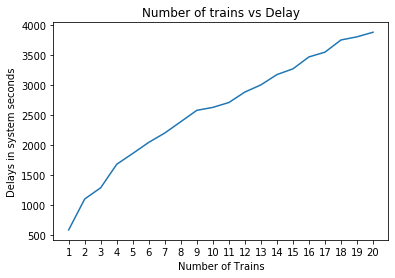

In [45]:
# x axis values 
x= np. arange(1,21) # Total 20 trains
# corresponding y axis values 
y = df_summary_temp['Delay'] # Delays per train
  
# plotting the points  
plt.plot(x, y) 
  
# naming the x axis 
plt.xlabel('Number of Trains') 
# naming the y axis 
plt.ylabel('Delays in system seconds') 
  
# giving a title to the graph 
plt.title('Number of trains vs Delay') 

plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# function to show the plot 
plt.show()

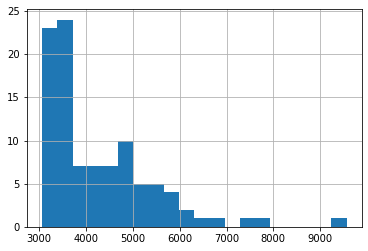

In [46]:
Optimization_Dataframe['Avg_Travel_Time'].hist(bins=20)

Below graph shows that Passengers backlog is reduced as more trains pass through

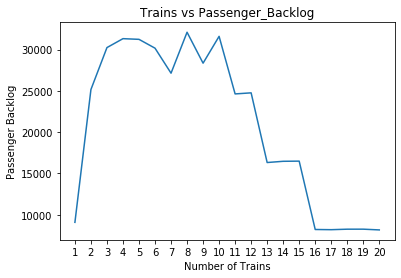

In [47]:
# x axis values 
x= np. arange(1,21) # Total 20 trains
# corresponding y axis values 
y = df_summary_temp['Passenger_Backlog'] # Passenger Backlog per train
  
# plotting the points  
plt.plot(x, y) 
  
# naming the x axis 
plt.xlabel('Number of Trains') 
# naming the y axis 
plt.ylabel('Passenger Backlog') 
  
# giving a title to the graph 
plt.title('Trains vs Passenger_Backlog') 

plt.xticks(np.arange(min(x), max(x)+1, 1.0))
# function to show the plot 
plt.show()

# References

[SimPy](https://simpy.readthedocs.io/en/latest/contents.html)

[pythonhosted](https://pythonhosted.org/SimPy/Manuals/SManual.html)